In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


For the fine-tuning process, I convert the dataset to the YOLO format from x,y, width and height to x_center ,y_center ,width and height, then I organized into YOLO compatible format (annotations and directory structure, then i load the model yolov10n.pt, I create data.yaml file with training and validations path. Then for the training , I specified 3 epochs because It take so long for training , like one epoch takes 35min , so it was impossible to train it for 100 epochs.Finally I plot some examples for testing .



In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 17.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import os
import shutil
import yaml
from IPython.display import Image, clear_output 

In [4]:
import os 

os.listdir('/kaggle/input/')

base_path = "/kaggle/input/coco-2017-dataset/coco2017"
print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['person_keypoints_train2017.json', 'instances_val2017.json', 'instances_train2017.json', 'person_keypoints_val2017.json', 'captions_train2017.json', 'captions_val2017.json']
Training images: 118287
Validation images: 5000
Test images: 40670


In [5]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.6 MB/s eta 0:00:00:00:01


In [6]:
import json
from pycocotools.coco import COCO
import os

train_annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"
val_annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json"
train_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
val_images_dir = "/kaggle/input/coco-2017-dataset/coco2017/val2017"
output_labels_train_dir = "/kaggle/working/dataset/labels/train"
output_labels_val_dir = "/kaggle/working/dataset/labels/val"

os.makedirs(output_labels_train_dir, exist_ok=True)
os.makedirs(output_labels_val_dir, exist_ok=True)

nc = 80
def convert_yolo_format(image_width, image_height, bbox):
    x, y, w, h = bbox
    x_center = (x + w / 2) / image_width
    y_center = (y + h / 2) / image_height
    w = w / image_width
    h = h / image_height
    return x_center, y_center, w, h

def process_coco_annotations(annotation_path, output_labels_dir, images_dir):
   
    coco = COCO(annotation_path)

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs([img_id])[0]
        img_filename = img_info['file_name']
        img_path = os.path.join(images_dir, img_filename)
        
        if not os.path.exists(img_path):
            print(f"Warning: {img_filename} not found in {images_dir}")
            continue

        img_width, img_height = img_info['width'], img_info['height']
        
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
        
        label_file_path = os.path.join(output_labels_dir, f"{img_filename.split('.')[0]}.txt")
        with open(label_file_path, 'w') as label_file:
            seen_labels = set()
            for ann in annotations:
                if 'bbox' in ann:
                    bbox = convert_yolo_format(img_width, img_height, ann['bbox'])
                    class_id = ann['category_id'] - 1
                    
                    if class_id >= nc:
                        # print(f"Warning: Class ID {class_id} in {img_filename} exceeds nc={nc}. Skipping this annotation.")
                        continue
                    label_str = f"{class_id} {' '.join(map(str, bbox))}\n"
                    if label_str not in seen_labels:
                        label_file.write(label_str)
                        seen_labels.add(label_str)
                    else:
                        print(f"Warning: Duplicate label found in {img_filename}. Skipping this annotation.")

# Process both training and validation annotations
process_coco_annotations(train_annotation_path, output_labels_train_dir, train_images_dir)
process_coco_annotations(val_annotation_path, output_labels_val_dir, val_images_dir)

loading annotations into memory...
Done (t=18.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [7]:
output_train_images_dir = "/kaggle/working/dataset/images/train"
output_val_images_dir = "/kaggle/working/dataset/images/val"
os.makedirs(output_train_images_dir, exist_ok=True)
os.makedirs(output_val_images_dir, exist_ok=True)

for img_filename in os.listdir(train_images_dir):
    img_path = os.path.join(train_images_dir, img_filename)
    symlink_path = os.path.join(output_train_images_dir, img_filename)
    if not os.path.exists(symlink_path):
        os.symlink(img_path, symlink_path)

for img_filename in os.listdir(val_images_dir):
    img_path = os.path.join(val_images_dir, img_filename)
    symlink_path = os.path.join(output_val_images_dir, img_filename)
    if not os.path.exists(symlink_path):
        os.symlink(img_path, symlink_path)


In [8]:
import json
from pycocotools.coco import COCO
annotation_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json"
coco = COCO(annotation_path)

categories = coco.loadCats(coco.getCatIds())
class_names = [category['name'] for category in categories]
print("Classes in COCO dataset:", class_names)

loading annotations into memory...
Done (t=16.84s)
creating index...
index created!
Classes in COCO dataset: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [9]:
data_yaml = """
train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/val
nc: 80  # Number of classes, which should be 80 for COCO dataset
names:
  0: 'person'
  1: 'bicycle'
  2: 'car'
  3: 'motorcycle'
  4: 'airplane'
  5: 'bus'
  6: 'train'
  7: 'truck'
  8: 'boat'
  9: 'traffic light'
  10: 'fire hydrant'
  11: 'N/A'
  12: 'stop sign'
  13: 'parking meter'
  14: 'bench'
  15: 'bird'
  16: 'cat'
  17: 'dog'
  18: 'horse'
  19: 'sheep'
  20: 'cow'
  21: 'elephant'
  22: 'bear'
  23: 'zebra'
  24: 'giraffe'
  25: 'N/A'
  26: 'backpack'
  27: 'umbrella'
  28: 'handbag'
  29: 'tie'
  30: 'suitcase'
  31: 'frisbee'
  32: 'skis'
  33: 'snowboard'
  34: 'sports ball'
  35: 'kite'
  36: 'baseball bat'
  37: 'baseball glove'
  38: 'skateboard'
  39: 'surfboard'
  40: 'tennis racket'
  41: 'bottle'
  42: 'wine glass'
  43: 'cup'
  44: 'fork'
  45: 'knife'
  46: 'spoon'
  47: 'bowl'
  48: 'banana'
  49: 'apple'
  50: 'sandwich'
  51: 'orange'
  52: 'broccoli'
  53: 'carrot'
  54: 'hot dog'
  55: 'pizza'
  56: 'donut'
  57: 'cake'
  58: 'chair'
  59: 'couch'
  60: 'potted plant'
  61: 'bed'
  62: 'dining table'
  63: 'toilet'
  64: 'tv'
  65: 'laptop'
  66: 'mouse'
  67: 'remote'
  68: 'keyboard'
  69: 'cell phone'
  70: 'microwave'
  71: 'oven'
  72: 'toaster'
  73: 'sink'
  74: 'refrigerator'
  75: 'book'
  76: 'clock'
  77: 'vase'
  78: 'scissors'
  79: 'teddy bear'
"""
with open('/kaggle/working/dataset/data.yaml', 'w') as f:
    f.write(data_yaml)

In [11]:
from ultralytics import YOLO
model = YOLO('yolov10n.pt')
model.train(data='/kaggle/working/dataset/data.yaml', epochs=3, batch=16, imgsz=640,lr0=0.001)


Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/kaggle/working/dataset/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /kaggle/working/dataset/labels/train.cache... 118287 images, 4296 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/val.cache... 5000 images, 198 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      7.13G       2.55      3.764      2.439        105        640: 100%|██████████| 7393/7393 [33:14<00:00,  3.71it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:35<00:00,  4.37it/s]


                   all       5000      34430        0.6      0.453      0.482      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      7.65G      2.557       3.18      2.449        178        640: 100%|██████████| 7393/7393 [31:56<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


                   all       5000      34430      0.622      0.468      0.507      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      7.48G      2.538      3.084      2.437        197        640: 100%|██████████| 7393/7393 [31:31<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:36<00:00,  4.25it/s]


                   all       5000      34430      0.633       0.48      0.524      0.371

3 epochs completed in 1.663 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.9MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.9MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,762,608 parameters, 0 gradients, 8.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:30<00:00,  5.16it/s]


                   all       5000      34430      0.633       0.48      0.524      0.371
                person       2693      11004      0.762      0.645      0.732      0.502
               bicycle        149        316      0.682      0.373      0.447       0.27
                   car        535       1932      0.656      0.503      0.564      0.361
            motorcycle        159        371      0.693      0.558      0.659      0.414
              airplane         97        143      0.805      0.755      0.827      0.656
                   bus        189        285      0.764      0.658      0.753      0.623
                 train        157        190      0.822      0.774      0.835      0.654
                 truck        250        415      0.576      0.395      0.453      0.311
                  boat        121        430      0.591      0.316       0.41      0.219
         traffic light        191        637      0.633      0.375      0.415      0.218
          fire hydran

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79cde1b15a20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,


image 1/1 /kaggle/input/coco-2017-dataset/coco2017/test2017/000000000001.jpg: 480x640 1 car, 1 truck, 1 parking meter, 14.8ms
Speed: 1.6ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg: 640x480 2 persons, 1 baseball bat, 1 skateboard, 10.5ms
Speed: 1.2ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


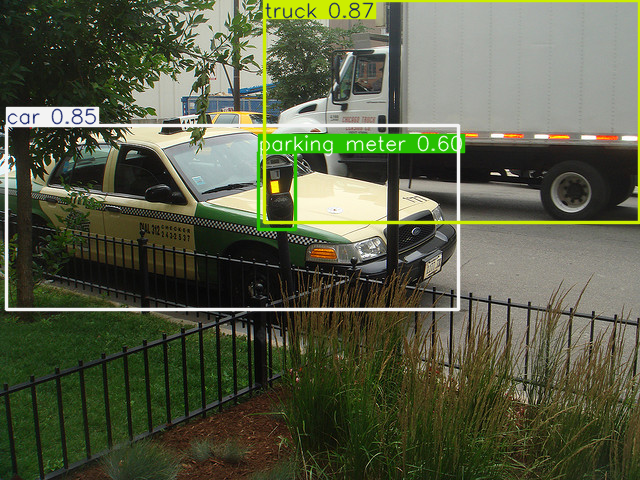

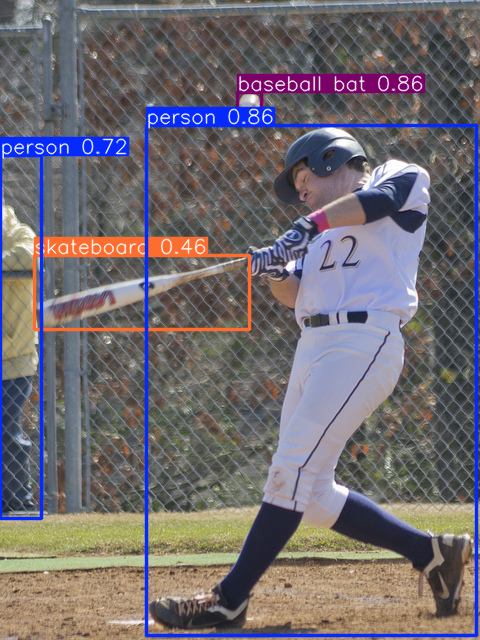

In [17]:
# Predict results for the images
results1 = model.predict(source='/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000001.jpg', imgsz=640, conf=0.25)
results2 = model.predict(source='/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg', imgsz=640, conf=0.25)

# Display or save the results
# Iterate over results if the predictions are in a list
for result in results1:
    result.show()

for result in results2:
    result.show()


In [21]:
model.save('/kaggle/working/model.h5')